In [1]:
pip install gdown google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

In [7]:
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import os

# المصادقة مع Google Drive
auth.authenticate_user()

# بناء خدمة Drive API
drive_service = build('drive', 'v3')

def list_files_in_folder(folder_id):
    """استرجاع قائمة بجميع الملفات في المجلد"""
    files = []
    page_token = None

    while True:
        response = drive_service.files().list(
            q=f"'{folder_id}' in parents",
            spaces='drive',
            fields='nextPageToken, files(id, name, mimeType)',
            pageToken=page_token
        ).execute()

        files.extend(response.get('files', []))
        page_token = response.get('nextPageToken', None)

        if page_token is None:
            break

    return files

def download_file(file_id, file_name, destination_folder):
    """تحميل ملف من Google Drive"""
    request = drive_service.files().get_media(fileId=file_id)

    file_path = os.path.join(destination_folder, file_name)
    os.makedirs(destination_folder, exist_ok=True)

    fh = io.FileIO(file_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print(f"تحميل {file_name}: {int(status.progress() * 100)}%")

    fh.close()
    print(f"✓ تم تحميل: {file_name}")

def download_folder_recursive(folder_id, destination_path=''):
    """تحميل مجلد كامل بشكل تكراري"""
    files = list_files_in_folder(folder_id)

    for file in files:
        file_id = file['id']
        file_name = file['name']
        mime_type = file['mimeType']

        if mime_type == 'application/vnd.google-apps.folder':
            # إذا كان مجلد، قم بالتحميل التكراري
            print(f"\n📁 دخول مجلد: {file_name}")
            new_path = os.path.join(destination_path, file_name)
            download_folder_recursive(file_id, new_path)
        else:
            # إذا كان ملف، قم بتحميله
            download_file(file_id, file_name, destination_path)

# معرف المجلد الرئيسي
main_folder_id = '1XDH-Xr1ZG_8shGrWGpKs4dtQcWPHzVqh'

# بدء التحميل
print("🚀 بدء تحميل المجلد...")
download_folder_recursive(main_folder_id, './downloaded_data')
print("\n✅ اكتمل التحميل!")

🚀 بدء تحميل المجلد...

📁 دخول مجلد: validation

📁 دخول مجلد: non shop lifters
تحميل videppppsss_52.mp4: 100%
✓ تم تحميل: videppppsss_52.mp4
تحميل videppppsss_54.mp4: 100%
✓ تم تحميل: videppppsss_54.mp4
تحميل videppppsss_18.mp4: 100%
✓ تم تحميل: videppppsss_18.mp4
تحميل videppppsss_41.mp4: 100%
✓ تم تحميل: videppppsss_41.mp4
تحميل videppppsss_16.mp4: 100%
✓ تم تحميل: videppppsss_16.mp4
تحميل videppppsss_80.mp4: 100%
✓ تم تحميل: videppppsss_80.mp4
تحميل videppppsss_36.mp4: 100%
✓ تم تحميل: videppppsss_36.mp4
تحميل videppppsss_2.mp4: 100%
✓ تم تحميل: videppppsss_2.mp4
تحميل videppppsss_9.mp4: 100%
✓ تم تحميل: videppppsss_9.mp4
تحميل videppppsss_57.mp4: 100%
✓ تم تحميل: videppppsss_57.mp4
تحميل videppppsss_26.mp4: 100%
✓ تم تحميل: videppppsss_26.mp4
تحميل videppppsss_17.mp4: 100%
✓ تم تحميل: videppppsss_17.mp4
تحميل videppppsss_1.mp4: 100%
✓ تم تحميل: videppppsss_1.mp4
تحميل videppppsss_10.mp4: 100%
✓ تم تحميل: videppppsss_10.mp4
تحميل videppppsss_0.mp4: 100%
✓ تم تحميل: videppppsss_0.mp4


In [8]:
import gdown

file_id = '1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-'
url = f'https://drive.google.com/drive/folders/1XDH-Xr1ZG_8shGrWGpKs4dtQcWPHzVqh?usp=sharing'
output = 'Shop_DataSet.zip'
gdown.download(url, output, quiet=False)

/usr/local/lib/python3.12/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/drive/folders/1XDH-Xr1ZG_8shGrWGpKs4dtQcWPHzVqh?usp=sharing
To: /content/Shop_DataSet.zip
1.28MB [00:00, 1.36MB/s]


'Shop_DataSet.zip'

In [11]:
import torch
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

class VideoDataset(Dataset):
    """
    Custom dataset for loading video frames
    """
    def __init__(self, root_dir, num_frames=16, train=True):
        """
        Args:
            root_dir: Directory containing video files or frame folders
            num_frames: Number of frames to extract from each video
            train: Whether this is training set (for augmentation)
        """
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.train = train
        self.videos = []
        self.labels = []

        # Get class folders
        self.classes = sorted([d for d in os.listdir(root_dir)
                               if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Load video paths and labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for video_name in os.listdir(class_dir):
                video_path = os.path.join(class_dir, video_name)
                if os.path.isdir(video_path) or video_name.endswith(('.mp4', '.avi', '.mov')):
                    self.videos.append(video_path)
                    self.labels.append(self.class_to_idx[class_name])

        # Data augmentation transforms
        if self.train:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = self.labels[idx]

        # Load frames from video
        frames = self._load_frames(video_path)

        # Apply transforms
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        # Stack frames into tensor (num_frames, channels, height, width)
        frames_tensor = torch.stack(frames)

        return frames_tensor, torch.tensor(label, dtype=torch.long)

    def _load_frames(self, video_path):
        """
        Load num_frames frames from video file or folder
        """
        frames = []

        # If it's a folder of images
        if os.path.isdir(video_path):
            frame_files = sorted([f for f in os.listdir(video_path)
                                if f.endswith(('.jpg', '.png', '.jpeg'))])
            frame_files = frame_files[:self.num_frames]

            for frame_file in frame_files:
                frame_path = os.path.join(video_path, frame_file)
                frame = cv2.imread(frame_path)
                if frame is not None:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, (256, 256))
                    frames.append(frame)

        # If it's a video file
        else:
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            if frame_count > 0:
                # Calculate step to sample num_frames evenly
                step = max(1, frame_count // self.num_frames)
                frame_idx = 0

                while len(frames) < self.num_frames:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                    ret, frame = cap.read()

                    if ret:
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frame = cv2.resize(frame, (256, 256))
                        frames.append(frame)
                        frame_idx += step
                    else:
                        break

            cap.release()

        # Pad with last frame if not enough frames
        while len(frames) < self.num_frames:
            if frames:
                frames.append(frames[-1])
            else:
                frames.append(np.zeros((256, 256, 3), dtype=np.uint8))

        return frames[:self.num_frames]


# ============================================
# Now create the datasets and dataloaders
# ============================================
from torch.utils.data import DataLoader

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Create datasets
train_dataset = VideoDataset(
    root_dir="/content/downloaded_data/train",
    num_frames=16,
    train=True
)

val_dataset = VideoDataset(
    root_dir="/content/downloaded_data/validation",
    num_frames=16,
    train=False
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

print(f"✅ Datasets loaded!")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Datasets loaded!
Train samples: 420
Val samples: 106
Classes: ['non shop lifters', 'shop lifters']


In [12]:
import os
import cv2
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Data prepairing and preprocessing

## Data Object

In [13]:
# Video Dataset Definition

class VideoDataset(Dataset):
    def __init__(self, root_dir, num_frames=16, train=True):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.videos = []
        self.num_frames = num_frames
        self.train = train

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}


        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                if file.endswith(('.mp4', '.avi', '.mov')):
                    self.videos.append({
                        'path': os.path.join(class_path, file),
                        'label': label
                    })

    def __len__(self):
        return len(self.videos)

    def read_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return frames

    def sample_frames(self, frames):
        total = len(frames)
        if total == 0:
            return None
        indices = np.linspace(0, total - 1, self.num_frames, dtype=int)
        return [frames[i] for i in indices]

    def get_transform(self):
        """Different for train vs validation."""
        base = [
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
        ]

        if not self.train:
            return transforms.Compose(base)

        # training augmentation (one per video)
        augmentations = [
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ColorJitter(brightness=0.3),
            transforms.ColorJitter(contrast=0.3),
            transforms.RandomRotation(degrees=10),
            None
        ]
        aug = random.choice(augmentations)
        if aug is not None:
            return transforms.Compose([aug] + base)
        return transforms.Compose(base)

    def __getitem__(self, idx):
        video_info = self.videos[idx]
        frames = self.read_video(video_info['path'])
        frames = self.sample_frames(frames)
        transform = self.get_transform()

        frames = [transform(Image.fromarray(f)) for f in frames]
        video_tensor = torch.stack(frames)  # [T, C, H, W]
        label = torch.tensor(video_info['label'])
        return video_tensor, label


## Splitting & Building the data loader

In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!ls "/content/downloaded_data"


train  validation


In [16]:
#  Dataset Split (Train / Val)
train_dataset = VideoDataset(root_dir="/content/downloaded_data/train", num_frames=16, train=True)
val_dataset = VideoDataset(root_dir="/content/downloaded_data/validation", num_frames=16, train=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")


Train: 420 | Val: 106


# Pretrained Model

## Model building

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os

# ============================================
# 1️⃣ Pretrained CNN-GRU Model with Transfer Learning
# ============================================
class PretrainedCNN_GRU_Model(nn.Module):
    def __init__(self, num_classes=1, num_frames=16, pretrained_model='resnet50'):
        """
        Args:
            num_classes: Number of output classes
            num_frames: Number of frames in video
            pretrained_model: 'resnet50', 'resnet18', 'vgg16', 'efficientnet_b0'
        """
        super(PretrainedCNN_GRU_Model, self).__init__()
        self.num_frames = num_frames

        # Load pretrained CNN backbone
        if pretrained_model == 'resnet50':
            self.cnn = models.resnet50(pretrained=True)
            cnn_output_features = 2048
        elif pretrained_model == 'resnet18':
            self.cnn = models.resnet18(pretrained=True)
            cnn_output_features = 512
        elif pretrained_model == 'vgg16':
            vgg = models.vgg16(pretrained=True)
            self.cnn = nn.Sequential(*list(vgg.features.children()))
            cnn_output_features = 512
        elif pretrained_model == 'efficientnet_b0':
            self.cnn = models.efficientnet_b0(pretrained=True)
            cnn_output_features = 1280
        else:
            raise ValueError(f"Unknown model: {pretrained_model}")

        # Remove classification layer from CNN
        if pretrained_model.startswith('resnet'):
            self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        elif pretrained_model == 'efficientnet_b0':
            self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])

        # Optional: Freeze early layers to preserve learned features
        self._freeze_early_layers(pretrained_model)

        # FC layer after CNN
        self.fc_after_cnn = nn.Sequential(
            nn.Linear(cnn_output_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # GRU layer for temporal modeling
        self.gru = nn.GRU(
            input_size=512,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )

        # Output layer
        self.fc_out = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes if num_classes > 1 else 1)
        )

    def _freeze_early_layers(self, model_name):
        """Freeze early layers to use pretrained features"""
        if model_name.startswith('resnet'):
            # Freeze all layers except layer4
            for name, param in self.cnn.named_parameters():
                if 'layer4' not in name:
                    param.requires_grad = False

    def forward(self, x):
        # x shape: (batch_size, num_frames, 3, height, width)
        batch_size, num_frames, c, h, w = x.shape

        # Process each frame through CNN
        x = x.view(batch_size * num_frames, c, h, w)
        x = self.cnn(x)
        x = x.view(batch_size * num_frames, -1)
        x = self.fc_after_cnn(x)

        # Reshape for GRU
        x = x.view(batch_size, num_frames, -1)
        x, _ = self.gru(x)

        # Get last output and pass through FC layers
        x = x[:, -1, :]
        x = self.fc_out(x)
        x = x.squeeze()

        return x


# ============================================
# 2️⃣ Create Pretrained Model
# ============================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Choose pretrained backbone
# Options: 'resnet50', 'resnet18', 'vgg16', 'efficientnet_b0'
model = PretrainedCNN_GRU_Model(
    num_classes=1,
    num_frames=16,
    pretrained_model='resnet50'  # Change this to try other models
)
model.to(device)

print("✅ Pretrained Model created successfully")
print(f"Model: ResNet50 + GRU")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params:,}")

# ============================================
# 3️⃣ Create Optimizer
# ============================================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)
print("\n✅ Optimizer created (Adam, lr=1e-4)")

# ============================================
# 4️⃣ Training Configuration
# ============================================
num_epochs = 10
checkpoint_path = "/content/drive/MyDrive/project/Checkpoints/best_pretrained_model.pth"

print("\n" + "="*60)
print("🎯 Configuration")
print("="*60)
print(f"Model: Pretrained ResNet50 + GRU")
print(f"Epochs: {num_epochs}")
print(f"Batch Size: 4")
print(f"Loss: BCEWithLogitsLoss")
print(f"Optimizer: Adam (lr=1e-4)")
print(f"Checkpoint: {checkpoint_path}")
print("="*60)

Device: cuda



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


✅ Pretrained Model created successfully
Model: ResNet50 + GRU
Total Parameters: 25,576,257
Trainable Parameters: 2,068,225


TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

In [ ]:
best_model, training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    checkpoint_path=checkpoint_path
)

## Training loop function

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
# Initialize the model
model = CNN_GRU_Model(num_classes=1)  # Adjust num_classes based on your task
model.to(device)

# Training Loop
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5

In [19]:
import torch
import torch.nn as nn

class CNN_GRU_Model(nn.Module):
    def __init__(self, num_classes=1):
        super(CNN_GRU_Model, self).__init__()
        # Define your CNN layers
        self.cnn = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),
            # Add more layers as needed
        )
        # Define your GRU layers
        self.gru = nn.GRU(input_size=32, hidden_size=64, num_layers=2, batch_first=True)
        # Output layer
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # Process through CNN and GRU
        return x

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# ============================================
# 1️⃣ تعريف الموديل (CNN-GRU)
# ============================================
class CNN_GRU_Model(nn.Module):
    def __init__(self, num_classes=1, num_frames=16):
        super(CNN_GRU_Model, self).__init__()
        self.num_frames = num_frames

        # CNN لمعالجة كل frame
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # حساب حجم الـ output من CNN
        self.cnn_output_size = 128 * (224 // 8) * (224 // 8)  # اعدل حسب حجم الصور

        # Flatten و Dense layer قبل GRU
        self.fc_before_gru = nn.Linear(self.cnn_output_size, 256)

        # GRU لمعالجة تسلسل الـ frames
        self.gru = nn.GRU(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )

        # Output layer
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, num_frames, channels, height, width)
        batch_size, num_frames, c, h, w = x.shape

        # معالجة كل frame بـ CNN
        x = x.view(batch_size * num_frames, c, h, w)
        x = self.cnn(x)
        x = x.view(batch_size * num_frames, -1)
        x = self.fc_before_gru(x)

        # إرجاع الـ sequence للـ GRU
        x = x.view(batch_size, num_frames, -1)
        x, _ = self.gru(x)

        # خذ آخر output من GRU
        x = x[:, -1, :]

        # Final output
        x = self.fc_out(x)
        return x


# ============================================
# 2️⃣ الخطوات الأساسية
# ============================================

# تحديد الـ device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ============================================
# 3️⃣ إنشاء الـ Model
# ============================================
model = CNN_GRU_Model(num_classes=1, num_frames=16)
model.to(device)
print(f"✅ Model created successfully on {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================
# 4️⃣ إنشاء ال Optimizer بعد ما عملنا الموديل
# ============================================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
print("✅ Optimizer created successfully")

# يمكنك كمان تستخدم learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# ============================================
# 5️⃣ الـ Dataset والـ DataLoaders
# ============================================
train_dataset = VideoDataset(root_dir="/content/downloaded_data/train", num_frames=16, train=True)
val_dataset = VideoDataset(root_dir="/content/downloaded_data/validation", num_frames=16, train=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")
print("✅ DataLoaders ready")

# ============================================
# معلومات عن الـ setup
# ============================================
print("\n" + "="*50)
print("🎯 Setup Summary:")
print("="*50)
print(f"Model: CNN_GRU")
print(f"Loss Function: BCEWithLogitsLoss")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Device: {device}")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print("="*50)

Device: cuda
✅ Model created successfully on cuda
Model parameters: 26,031,041
✅ Optimizer created successfully
Train: 420 | Val: 106
✅ DataLoaders ready

🎯 Setup Summary:
Model: CNN_GRU
Loss Function: BCEWithLogitsLoss
Optimizer: Adam (lr=0.001)
Device: cuda
Total Parameters: 26,031,041


## Training

In [21]:
import torch
import os

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    device,
    checkpoint_path
):
    """
    Training loop for CNN-GRU model
    """
    best_val_loss = float("inf")

    # Store training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")

        # ============ TRAINING ============
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for batch_idx, (videos, labels) in enumerate(train_loader):
            videos = videos.to(device)
            labels = labels.float().to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)

            # Predictions
            preds = (torch.sigmoid(outputs) > 0.5).long()
            running_corrects += torch.sum(preds == labels.long())
            running_loss += loss.item() * videos.size(0)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Print progress
            if (batch_idx + 1) % 10 == 0:
                print(f"Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"\nTrain Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

        # ============ VALIDATION ============
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for videos, labels in val_loader:
                videos = videos.to(device)
                labels = labels.float().to(device)

                # Forward pass
                outputs = model(videos)
                loss = criterion(outputs, labels)

                # Predictions
                preds = (torch.sigmoid(outputs) > 0.5).long()
                val_corrects += torch.sum(preds == labels.long())
                val_loss += loss.item() * videos.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

        # ============ STORE RESULTS ============
        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(epoch_acc.item())
        history["val_acc"].append(val_acc.item())

        # ============ SAVE CHECKPOINT ============
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✅ Best model saved! Val Loss: {val_loss:.4f}")

        # ============ LEARNING RATE SCHEDULER ============
        scheduler.step()

    print("\n" + "="*60)
    print("✅ Training Complete!")
    print(f"Best Val Loss: {best_val_loss:.4f}")
    print("="*60)

    return model, history

In [22]:
# معرفة حجم الصور الفعلي
batch = next(iter(train_loader))
videos, labels = batch
print(f"Videos shape: {videos.shape}")
print(f"Video dimensions: {videos.shape[3]}x{videos.shape[4]}")

Videos shape: torch.Size([4, 16, 3, 256, 256])
Video dimensions: 256x256


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os

# ============================================
# 1️⃣ Define CNN_GRU Model
# ============================================
class CNN_GRU_Model(nn.Module):
    def __init__(self, num_classes=1, num_frames=16, input_height=256, input_width=256):
        super(CNN_GRU_Model, self).__init__()
        self.num_frames = num_frames

        # CNN for processing each frame
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Calculate CNN output size
        final_height = input_height // (2**3)
        final_width = input_width // (2**3)
        self.cnn_output_size = 128 * final_height * final_width

        # FC layer before GRU
        self.fc_before_gru = nn.Linear(self.cnn_output_size, 256)

        # GRU layer
        self.gru = nn.GRU(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )

        # Output layer
        self.fc_out = nn.Linear(128, num_classes if num_classes > 1 else 1)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape

        # Process frames through CNN
        x = x.view(batch_size * num_frames, c, h, w)
        x = self.cnn(x)
        x = x.view(batch_size * num_frames, -1)
        x = self.fc_before_gru(x)

        # Reshape for GRU
        x = x.view(batch_size, num_frames, -1)
        x, _ = self.gru(x)

        # Get last output
        x = x[:, -1, :]
        x = self.fc_out(x)
        x = x.squeeze()

        return x


# ============================================
# 2️⃣ Create Model
# ============================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = CNN_GRU_Model(num_classes=1, num_frames=16, input_height=256, input_width=256)
model.to(device)
print(f"✅ Model created successfully")
print(f"CNN output size: {model.cnn_output_size}")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================
# 3️⃣ Create Optimizer
# ============================================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
print("✅ Optimizer created")

# ============================================
# 4️⃣ Training parameters
# ============================================
num_epochs = 5
checkpoint_path = "/content/drive/MyDrive/project/Checkpoints/best_CNN_GRU_model.pth"

print("\n" + "="*60)
print("Ready to train!")
print(f"Epochs: {num_epochs}")
print(f"Checkpoint: {checkpoint_path}")
print("="*60)

Device: cuda
✅ Model created successfully
CNN output size: 131072
Total Parameters: 33,895,361
✅ Optimizer created

Ready to train!
Epochs: 5
Checkpoint: /content/drive/MyDrive/project/Checkpoints/best_CNN_GRU_model.pth


In [26]:
# Now run training
best_model, training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    checkpoint_path=checkpoint_path
)


Epoch 1/5
Batch 10/105 - Loss: 0.7593
Batch 20/105 - Loss: 0.6352
Batch 30/105 - Loss: 0.9219
Batch 40/105 - Loss: 0.6800
Batch 50/105 - Loss: 0.6411
Batch 60/105 - Loss: 0.7007
Batch 70/105 - Loss: 0.7031
Batch 80/105 - Loss: 0.6885
Batch 90/105 - Loss: 0.7779
Batch 100/105 - Loss: 0.7170

Train Loss: 0.7193 | Accuracy: 0.5143
Val Loss: 0.6916 | Accuracy: 0.5283
✅ Best model saved! Val Loss: 0.6916

Epoch 2/5
Batch 10/105 - Loss: 0.7255
Batch 20/105 - Loss: 0.6889
Batch 30/105 - Loss: 0.6812
Batch 40/105 - Loss: 0.6282
Batch 50/105 - Loss: 0.5410
Batch 60/105 - Loss: 0.8054
Batch 70/105 - Loss: 0.6128
Batch 80/105 - Loss: 0.7308
Batch 90/105 - Loss: 0.6719
Batch 100/105 - Loss: 0.7125

Train Loss: 0.7042 | Accuracy: 0.5286
Val Loss: 0.7235 | Accuracy: 0.4717

Epoch 3/5
Batch 10/105 - Loss: 0.7243
Batch 20/105 - Loss: 0.7077
Batch 30/105 - Loss: 0.6682
Batch 40/105 - Loss: 0.6360
Batch 50/105 - Loss: 0.7460
Batch 60/105 - Loss: 0.7323
Batch 70/105 - Loss: 0.6450
Batch 80/105 - Loss: 0

# Evaluation

In [28]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in val_loader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        preds = (torch.sigmoid(outputs) > 0.5).long()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 5️⃣ Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Validation Accuracy: 0.3774
Precision: 0.4000
Recall: 0.6400
F1 Score: 0.4923


In [29]:
# 1️⃣ Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 2️⃣ Classification report (precision, recall, f1-score)
report = classification_report(all_labels, all_preds, target_names=["Non-Shoplifting", "Shoplifting"])
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[ 8 48]
 [18 32]]

Classification Report:
                 precision    recall  f1-score   support

Non-Shoplifting       0.31      0.14      0.20        56
    Shoplifting       0.40      0.64      0.49        50

       accuracy                           0.38       106
      macro avg       0.35      0.39      0.34       106
   weighted avg       0.35      0.38      0.34       106



## plotting history

Training Model 1...

Epoch 1/5
Batch 10/105 - Loss: 0.6926
Batch 20/105 - Loss: 0.7268
Batch 30/105 - Loss: 0.6680
Batch 40/105 - Loss: 0.6956
Batch 50/105 - Loss: 0.6539
Batch 60/105 - Loss: 0.6426
Batch 70/105 - Loss: 0.7612
Batch 80/105 - Loss: 0.7134
Batch 90/105 - Loss: 0.6825
Batch 100/105 - Loss: 0.6884

Train Loss: 0.6950 | Accuracy: 0.5214
Val Loss: 0.6864 | Accuracy: 0.5283
✅ Best model saved! Val Loss: 0.6864

Epoch 2/5
Batch 10/105 - Loss: 0.6472
Batch 20/105 - Loss: 0.7388
Batch 30/105 - Loss: 0.7748
Batch 40/105 - Loss: 0.6384
Batch 50/105 - Loss: 0.6788
Batch 60/105 - Loss: 0.7109
Batch 70/105 - Loss: 0.7025
Batch 80/105 - Loss: 0.6862
Batch 90/105 - Loss: 0.6844
Batch 100/105 - Loss: 0.6782

Train Loss: 0.6892 | Accuracy: 0.5524
Val Loss: 0.6795 | Accuracy: 0.4717
✅ Best model saved! Val Loss: 0.6795

Epoch 3/5
Batch 10/105 - Loss: 0.7038
Batch 20/105 - Loss: 0.6849
Batch 30/105 - Loss: 0.6594
Batch 40/105 - Loss: 0.6353
Batch 50/105 - Loss: 0.5524
Batch 60/105 - Loss: 

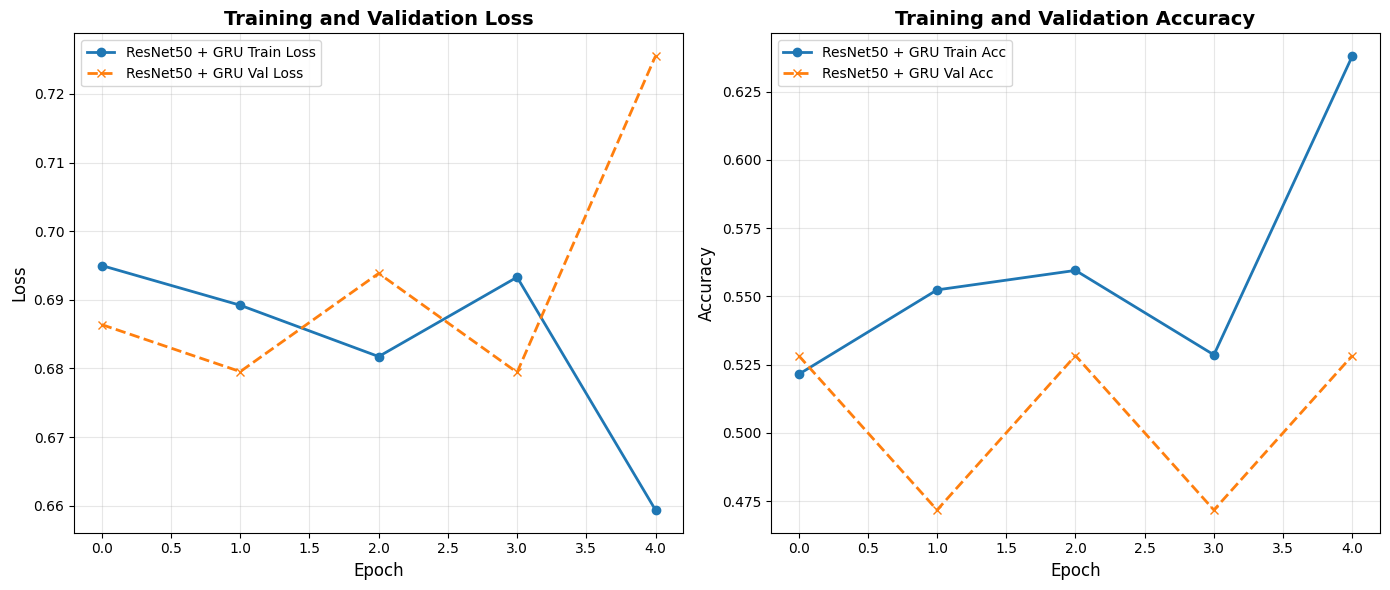

In [31]:
import matplotlib.pyplot as plt

def plot_history(histories, labels):
    """
    Plot training history from multiple runs

    Args:
        histories: list of history dictionaries from train_model()
        labels: list of labels for each history (e.g., ["Model1", "Model2"])
    """
    plt.figure(figsize=(14, 6))

    # ----- Plot Loss -----
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history["train_loss"], marker='o', linestyle='-', label=f"{label} Train Loss", linewidth=2)
        plt.plot(history["val_loss"], marker='x', linestyle='--', label=f"{label} Val Loss", linewidth=2)

    plt.title("Training and Validation Loss", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # ----- Plot Accuracy -----
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history["train_acc"], marker='o', linestyle='-', label=f"{label} Train Acc", linewidth=2)
        plt.plot(history["val_acc"], marker='x', linestyle='--', label=f"{label} Val Acc", linewidth=2)

    plt.title("Training and Validation Accuracy", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ============================================
# How to use:
# ============================================

# Step 1: Train your first model and save history
print("Training Model 1...")
best_model1, history1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=5,
    device=device,
    checkpoint_path="/content/drive/MyDrive/project/Checkpoints/model1.pth"
)

# Step 2: Create/train more models if needed (optional)
# print("Training Model 2...")
# best_model2, history2 = train_model(...)

# Step 3: Plot all histories together
print("\nPlotting training history...")
plot_history(
    [history1],  # Add more histories here: [history1, history2, history3, ...]
    ["ResNet50 + GRU"]  # Add corresponding labels
)

# ============================================
# To plot multiple models:
# ============================================
# plot_history(
#     [history1, history2, history3],
#     ["Model1", "Model2", "Model3"]
# )


Epoch 1/5
Batch 10/105 - Loss: 0.6063
Batch 20/105 - Loss: 1.0961
Batch 30/105 - Loss: 0.5711
Batch 40/105 - Loss: 0.6640
Batch 50/105 - Loss: 0.4163
Batch 60/105 - Loss: 0.4945
Batch 70/105 - Loss: 0.2444
Batch 80/105 - Loss: 0.3058
Batch 90/105 - Loss: 0.2781
Batch 100/105 - Loss: 1.0149

Train Loss: 0.5473 | Accuracy: 0.7476
Val Loss: 0.4429 | Accuracy: 0.8302
✅ Best model saved! Val Loss: 0.4429

Epoch 2/5
Batch 10/105 - Loss: 0.2704
Batch 20/105 - Loss: 0.4949
Batch 30/105 - Loss: 0.6468
Batch 40/105 - Loss: 0.3808
Batch 50/105 - Loss: 0.4690
Batch 60/105 - Loss: 0.3022
Batch 70/105 - Loss: 0.3316
Batch 80/105 - Loss: 0.8116
Batch 90/105 - Loss: 1.1354
Batch 100/105 - Loss: 0.8938

Train Loss: 0.6066 | Accuracy: 0.6952
Val Loss: 0.3957 | Accuracy: 0.8774
✅ Best model saved! Val Loss: 0.3957

Epoch 3/5
Batch 10/105 - Loss: 0.5090
Batch 20/105 - Loss: 0.5924
Batch 30/105 - Loss: 0.5155
Batch 40/105 - Loss: 0.3445
Batch 50/105 - Loss: 0.3008
Batch 60/105 - Loss: 0.3066
Batch 70/105 

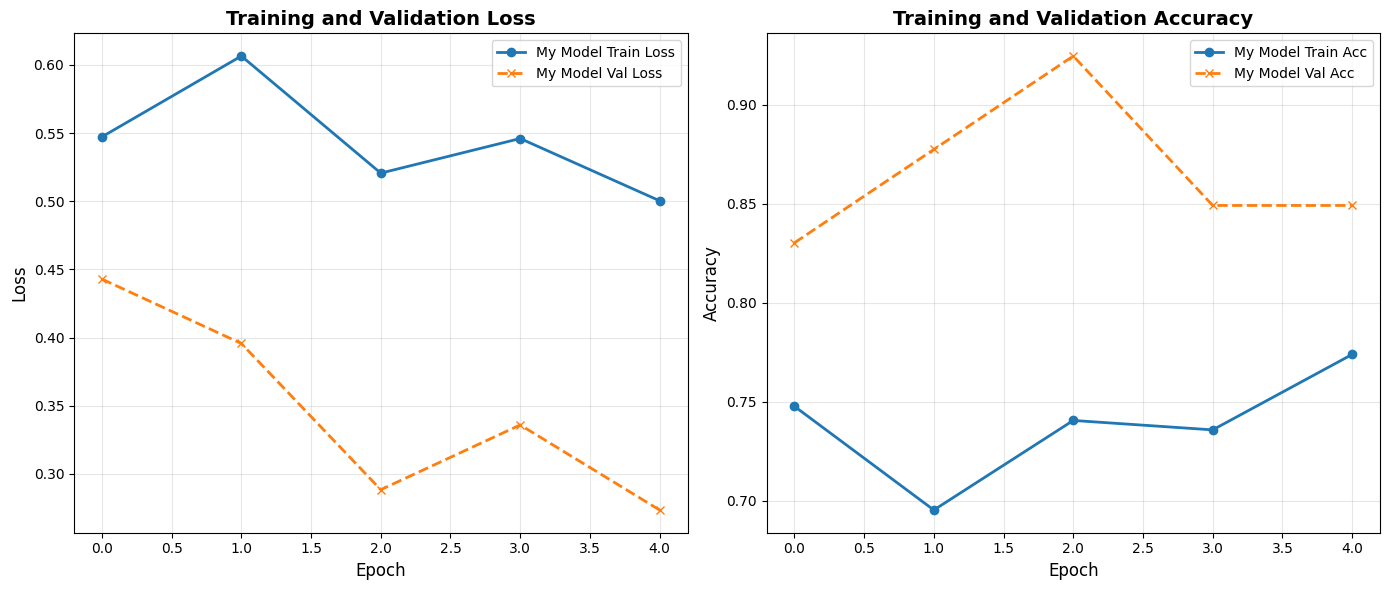

In [32]:
# Train and save history
best_model, training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=5,
    device=device,
    checkpoint_path=checkpoint_path
)

# Plot the history
plot_history([training_history], ["My Model"])

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# ============================================
# MODEL ARCHITECTURE: CNN + GRU
# ============================================

class ShopliftingDetector(nn.Module):
    """
    CNN+GRU architecture for video-based shoplifting detection.
    - Uses ResNet50 as feature extractor (CNN)
    - GRU processes temporal sequence of features
    - Binary classification output
    """

    def __init__(self, hidden_size=512, num_layers=2, dropout=0.3):
        super(ShopliftingDetector, self).__init__()

        # Feature extractor: ResNet50 (pretrained on ImageNet)
        resnet = models.resnet50(weights='IMAGENET1K_V1')  # Fixed deprecation warning
        # Remove the final FC layer
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

        # Freeze early layers (optional - can fine-tune)
        for param in list(self.feature_extractor.parameters())[:-20]:
            param.requires_grad = False

        # ResNet50 output dimension
        self.feature_dim = 2048

        # GRU for temporal modeling
        self.gru = nn.GRU(
            input_size=self.feature_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, 256),  # *2 for bidirectional
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(256, 1)  # Binary classification
        )

    def forward(self, x):
        """
        Args:
            x: [batch_size, num_frames, channels, height, width]
        Returns:
            output: [batch_size, 1] - logits for binary classification
        """
        batch_size, num_frames, c, h, w = x.size()

        # Extract features for each frame
        # Reshape to [batch_size * num_frames, c, h, w]
        x = x.view(batch_size * num_frames, c, h, w)

        # Extract features: [batch_size * num_frames, 2048, 1, 1]
        features = self.feature_extractor(x)

        # Flatten: [batch_size * num_frames, 2048]
        features = features.view(batch_size * num_frames, self.feature_dim)

        # Reshape back to sequence: [batch_size, num_frames, 2048]
        features = features.view(batch_size, num_frames, self.feature_dim)

        # GRU processing: output [batch_size, num_frames, hidden_size*2]
        gru_out, _ = self.gru(features)

        # Use last timestep output for classification
        last_output = gru_out[:, -1, :]  # [batch_size, hidden_size*2]

        # Classification
        output = self.classifier(last_output)  # [batch_size, 1]

        return output.squeeze(1)  # [batch_size]


# ============================================
# INITIALIZE MODEL
# ============================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model instance
model = ShopliftingDetector(
    hidden_size=512,
    num_layers=2,
    dropout=0.3
)
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler (removed 'verbose' parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

print(f"\nModel Architecture:")
print(f"- Feature Extractor: ResNet50 (pretrained)")
print(f"- Temporal Model: Bidirectional GRU (2 layers, 512 hidden units)")
print(f"- Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"- Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


# ============================================
# TRAINING CONFIGURATION
# ============================================

num_epochs = 20
checkpoint_path = "/content/drive/MyDrive/project/Checkpoints/best_shoplifting_model.pth"

print(f"\nTraining Configuration:")
print(f"- Epochs: {num_epochs}")
print(f"- Learning Rate: 1e-4")
print(f"- Batch Size: 4")
print(f"- Loss: BCEWithLogitsLoss")
print(f"- Optimizer: Adam with weight decay")
print(f"- Checkpoint: {checkpoint_path}")

Using device: cuda

Model Architecture:
- Feature Extractor: ResNet50 (pretrained)
- Temporal Model: Bidirectional GRU (2 layers, 512 hidden units)
- Total Parameters: 36,365,889
- Trainable Parameters: 21,787,137

Training Configuration:
- Epochs: 20
- Learning Rate: 1e-4
- Batch Size: 4
- Loss: BCEWithLogitsLoss
- Optimizer: Adam with weight decay
- Checkpoint: /content/drive/MyDrive/project/Checkpoints/best_shoplifting_model.pth


In [35]:
import os
import torch
from tqdm import tqdm

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    device,
    checkpoint_path
):
    """
    Complete training loop with validation and checkpointing
    """
    best_val_loss = float("inf")

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")

        # ==================== TRAINING ====================
        model.train()
        train_loss = 0.0
        train_corrects = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc="Training", leave=False)
        for videos, labels in train_pbar:
            # Move to device
            videos = videos.to(device)  # [batch, frames, C, H, W]
            labels = labels.float().to(device)  # [batch]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(videos)  # [batch]
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping (prevent exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            optimizer.step()

            # Statistics
            preds = (torch.sigmoid(outputs) > 0.5).long()
            train_corrects += (preds == labels.long()).sum().item()
            train_total += labels.size(0)
            train_loss += loss.item() * labels.size(0)

            # Update progress bar
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{train_corrects/train_total:.4f}'
            })

        # Calculate epoch metrics
        epoch_train_loss = train_loss / train_total
        epoch_train_acc = train_corrects / train_total

        # ==================== VALIDATION ====================
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc="Validation", leave=False)
            for videos, labels in val_pbar:
                videos = videos.to(device)
                labels = labels.float().to(device)

                # Forward pass
                outputs = model(videos)
                loss = criterion(outputs, labels)

                # Statistics
                preds = (torch.sigmoid(outputs) > 0.5).long()
                val_corrects += (preds == labels.long()).sum().item()
                val_total += labels.size(0)
                val_loss += loss.item() * labels.size(0)

                # Update progress bar
                val_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{val_corrects/val_total:.4f}'
                })

        # Calculate epoch metrics
        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_corrects / val_total

        # Update scheduler
        scheduler.step(epoch_val_loss)

        # Store history
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_acc"].append(epoch_val_acc)

        # Print epoch summary
        print(f"\nResults:")
        print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.4f}")

        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': epoch_val_loss,
                'val_acc': epoch_val_acc,
            }, checkpoint_path)
            print(f"  ✅ Best model saved! (Val Loss: {best_val_loss:.4f})")

    print(f"\n{'='*60}")
    print("Training Complete!")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"{'='*60}")

    return model, history


# ============================================
# START TRAINING
# ============================================

print("Starting training process...")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Train the model
trained_model, training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    checkpoint_path=checkpoint_path
)

print("\n✅ Training completed successfully!")

Starting training process...
Train samples: 420
Val samples: 106
Train batches: 105
Val batches: 27

Epoch 1/20



Results:
  Train Loss: 0.5268 | Train Acc: 0.7762
  Val Loss:   0.1540 | Val Acc:   0.9528
  ✅ Best model saved! (Val Loss: 0.1540)

Epoch 2/20



Results:
  Train Loss: 0.3391 | Train Acc: 0.8905
  Val Loss:   0.1589 | Val Acc:   0.9528

Epoch 3/20



Results:
  Train Loss: 0.3250 | Train Acc: 0.9119
  Val Loss:   0.0046 | Val Acc:   1.0000
  ✅ Best model saved! (Val Loss: 0.0046)

Epoch 4/20



Results:
  Train Loss: 0.2657 | Train Acc: 0.9262
  Val Loss:   0.0307 | Val Acc:   0.9811

Epoch 5/20



Results:
  Train Loss: 0.2432 | Train Acc: 0.9357
  Val Loss:   0.2285 | Val Acc:   0.9434

Epoch 6/20



Results:
  Train Loss: 0.3034 | Train Acc: 0.9214
  Val Loss:   0.0420 | Val Acc:   0.9906

Epoch 7/20



Results:
  Train Loss: 0.1563 | Train Acc: 0.9595
  Val Loss:   0.0010 | Val Acc:   1.0000
  ✅ Best model saved! (Val Loss: 0.0010)

Epoch 8/20



Results:
  Train Loss: 0.1661 | Train Acc: 0.9500
  Val Loss:   0.3144 | Val Acc:   0.9340

Epoch 9/20



Results:
  Train Loss: 0.1986 | Train Acc: 0.9548
  Val Loss:   0.0011 | Val Acc:   1.0000

Epoch 10/20



Results:
  Train Loss: 0.1040 | Train Acc: 0.9762
  Val Loss:   0.0234 | Val Acc:   0.9906

Epoch 11/20



Results:
  Train Loss: 0.0985 | Train Acc: 0.9762
  Val Loss:   0.0027 | Val Acc:   1.0000

Epoch 12/20



Results:
  Train Loss: 0.0757 | Train Acc: 0.9857
  Val Loss:   0.0008 | Val Acc:   1.0000
  ✅ Best model saved! (Val Loss: 0.0008)

Epoch 13/20



Results:
  Train Loss: 0.0213 | Train Acc: 0.9881
  Val Loss:   0.0002 | Val Acc:   1.0000
  ✅ Best model saved! (Val Loss: 0.0002)

Epoch 14/20



Results:
  Train Loss: 0.0154 | Train Acc: 0.9952
  Val Loss:   0.0001 | Val Acc:   1.0000
  ✅ Best model saved! (Val Loss: 0.0001)

Epoch 15/20



Results:
  Train Loss: 0.0169 | Train Acc: 0.9952
  Val Loss:   0.0002 | Val Acc:   1.0000

Epoch 16/20



Results:
  Train Loss: 0.0602 | Train Acc: 0.9881
  Val Loss:   0.0002 | Val Acc:   1.0000

Epoch 17/20



Results:
  Train Loss: 0.0057 | Train Acc: 0.9952
  Val Loss:   0.0002 | Val Acc:   1.0000

Epoch 18/20



Results:
  Train Loss: 0.0368 | Train Acc: 0.9905
  Val Loss:   0.0001 | Val Acc:   1.0000
  ✅ Best model saved! (Val Loss: 0.0001)

Epoch 19/20



Results:
  Train Loss: 0.0570 | Train Acc: 0.9857
  Val Loss:   0.0001 | Val Acc:   1.0000

Epoch 20/20



Results:
  Train Loss: 0.0279 | Train Acc: 0.9952
  Val Loss:   0.0001 | Val Acc:   1.0000

Training Complete!
Best Validation Loss: 0.0001

✅ Training completed successfully!


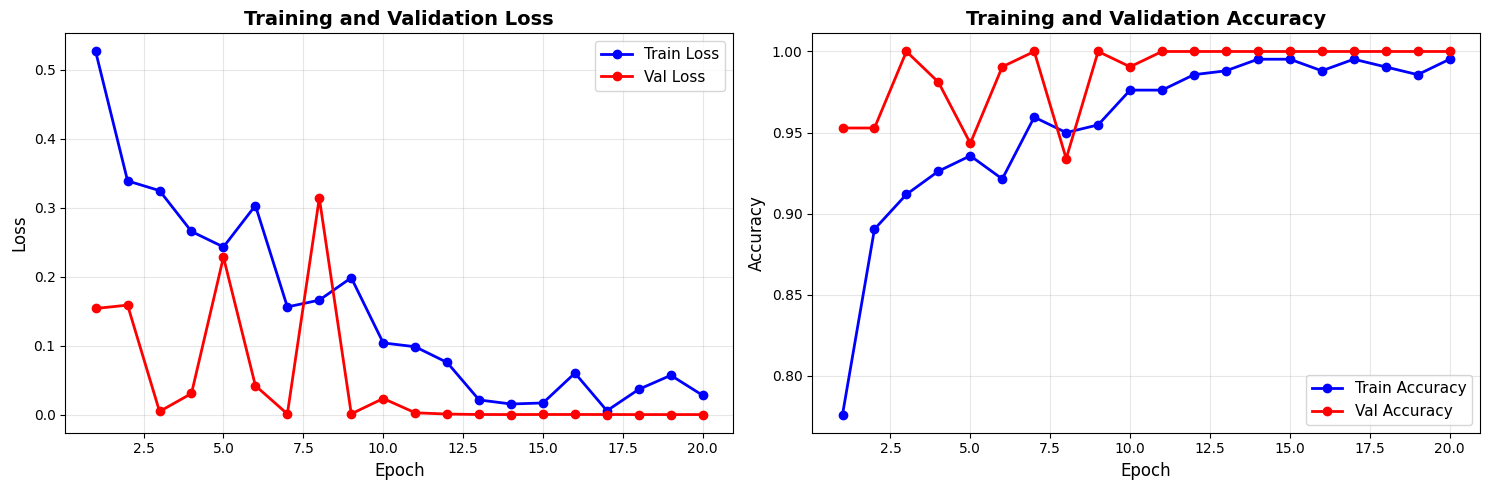


Final Results:
Best Train Loss: 0.0057
Best Val Loss:   0.0001
Best Train Acc:  0.9952
Best Val Acc:    1.0000


In [37]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and validation loss and accuracy
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Plot Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-o', label='Val Accuracy', linewidth=2)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print(f"\n{'='*50}")
    print("Final Results:")
    print(f"{'='*50}")
    print(f"Best Train Loss: {min(history['train_loss']):.4f}")
    print(f"Best Val Loss:   {min(history['val_loss']):.4f}")
    print(f"Best Train Acc:  {max(history['train_acc']):.4f}")
    print(f"Best Val Acc:    {max(history['val_acc']):.4f}")
    print(f"{'='*50}")

# After training completes, plot the results
plot_training_history(training_history)